In [ ]:
pip install numpy pandas matplotlib seaborn scikit-learn torch torchvision

In [ ]:
# Trafik Kazası Tahmini - Makine Öğrenmesi Projesi
# Bu proje trafik kazası verilerini analiz ederek kaza riskini tahmin etmeyi amaçlar

# 1. Gerekli kütüphanelerin yüklenmesi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# TabNet için basit implementasyon
class TabNet(nn.Module):
    def __init__(self, input_dim, output_dim=2, n_d=32, n_a=32, n_steps=3):
        super(TabNet, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps

        # Feature transformer
        self.initial_bn = nn.BatchNorm1d(input_dim)

        # Shared layers
        self.shared_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim if i == 0 else n_d, n_d),
                nn.BatchNorm1d(n_d),
                nn.ReLU()
            ) for i in range(n_steps)
        ])

        # Decision layers
        self.decision_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(n_d, n_d),
                nn.BatchNorm1d(n_d),
                nn.ReLU(),
                nn.Linear(n_d, output_dim)
            ) for _ in range(n_steps)
        ])

        # Attention layers
        self.attention_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(n_d if i > 0 else input_dim, n_a),
                nn.BatchNorm1d(n_a),
                nn.ReLU(),
                nn.Linear(n_a, input_dim),
                nn.Sigmoid()
            ) for i in range(n_steps)
        ])

    def forward(self, x):
        x = self.initial_bn(x)
        outputs = []

        for step in range(self.n_steps):
            # Attention
            if step == 0:
                attention = self.attention_layers[step](x)
            else:
                attention = self.attention_layers[step](shared_out)

            # Apply attention
            masked_x = x * attention

            # Shared processing
            if step == 0:
                shared_out = self.shared_layers[step](masked_x)
            else:
                shared_out = self.shared_layers[step](shared_out)

            # Decision
            decision_out = self.decision_layers[step](shared_out)
            outputs.append(decision_out)

        # Aggregate outputs
        final_output = torch.stack(outputs, dim=0).mean(dim=0)
        return final_output

class TabNetClassifier:
    def __init__(self, input_dim, output_dim=2, n_d=32, n_a=32, n_steps=3,
                 learning_rate=0.02, batch_size=256, epochs=100):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = TabNet(input_dim, output_dim, n_d, n_a, n_steps).to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.batch_size = batch_size
        self.epochs = epochs
        self.scaler = StandardScaler()

    def fit(self, X, y):
        # Veriyi ölçeklendir
        X_scaled = self.scaler.fit_transform(X)

        # Tensor'lara dönüştür
        X_tensor = torch.FloatTensor(X_scaled).to(self.device)
        y_tensor = torch.LongTensor(y.values if hasattr(y, 'values') else y).to(self.device)

        # DataLoader oluştur
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        # Eğitim
        self.model.train()
        for epoch in range(self.epochs):
            total_loss = 0
            for batch_X, batch_y in dataloader:
                self.optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            if (epoch + 1) % 20 == 0:
                print(f'TabNet Epoch [{epoch+1}/{self.epochs}], Loss: {total_loss/len(dataloader):.4f}')

        return self

    def predict(self, X):
        self.model.eval()
        X_scaled = self.scaler.transform(X)
        X_tensor = torch.FloatTensor(X_scaled).to(self.device)

        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs.data, 1)

        return predicted.cpu().numpy()

    def predict_proba(self, X):
        self.model.eval()
        X_scaled = self.scaler.transform(X)
        X_tensor = torch.FloatTensor(X_scaled).to(self.device)

        with torch.no_grad():
            outputs = self.model(X_tensor)
            probabilities = torch.softmax(outputs, dim=1)

        return probabilities.cpu().numpy()

# Grafik ayarları
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚗 Trafik Kazası Tahmini Projesi")
print("=" * 50)


🚗 Trafik Kazası Tahmini Projesi


In [ ]:
# 2. Sentetik veri seti oluşturma (gerçek bir veri seti yoksa)
np.random.seed(42)

def create_traffic_accident_dataset(n_samples=5000):
    """
    Gerçekçi trafik kazası veri seti oluşturur
    """
    data = {}

    # Hava durumu (0: Güneşli, 1: Yağmurlu, 2: Karlı, 3: Sisli)
    data['hava_durumu'] = np.random.choice([0, 1, 2, 3], n_samples, p=[0.5, 0.3, 0.1, 0.1])

    # Yol tipi (0: Şehir içi, 1: Otoyol, 2: Kırsal)
    data['yol_tipi'] = np.random.choice([0, 1, 2], n_samples, p=[0.6, 0.3, 0.1])

    # Trafik yoğunluğu (0: Az, 1: Orta, 2: Yoğun)
    data['trafik_yogunlugu'] = np.random.choice([0, 1, 2], n_samples, p=[0.3, 0.4, 0.3])

    # Hız limiti (km/h)
    data['hiz_limiti'] = np.random.choice([30, 50, 70, 90, 120], n_samples, p=[0.2, 0.3, 0.2, 0.2, 0.1])

    # Saat (0-23)
    data['saat'] = np.random.randint(0, 24, n_samples)

    # Gün (0: Pazartesi, 6: Pazar)
    data['gun'] = np.random.randint(0, 7, n_samples)

    # Yaş grubu (0: 18-30, 1: 31-50, 2: 51-70, 3: 70+)
    data['yas_grubu'] = np.random.choice([0, 1, 2, 3], n_samples, p=[0.3, 0.4, 0.2, 0.1])

    # Cinsiyet (0: Kadın, 1: Erkek)
    data['cinsiyet'] = np.random.choice([0, 1], n_samples, p=[0.4, 0.6])

    # Deneyim yılı
    data['deneyim_yili'] = np.random.randint(0, 40, n_samples)

    # Araç yaşı
    data['arac_yasi'] = np.random.randint(0, 20, n_samples)

    # Kaza riski hesaplama (hedef değişken)
    kaza_riski = (
        (data['hava_durumu'] == 1) * 0.3 +  # Yağmur
        (data['hava_durumu'] == 2) * 0.4 +  # Kar
        (data['hava_durumu'] == 3) * 0.35 + # Sis
        (data['trafik_yogunlugu'] == 2) * 0.2 +  # Yoğun trafik
        (data['hiz_limiti'] >= 90) * 0.15 +  # Yüksek hız
        ((data['saat'] >= 22) | (data['saat'] <= 6)) * 0.25 +  # Gece saatleri
        (data['gun'] >= 5) * 0.1 +  # Hafta sonu
        (data['yas_grubu'] == 0) * 0.2 +  # Genç sürücüler
        (data['yas_grubu'] == 3) * 0.15 +  # Yaşlı sürücüler
        (data['cinsiyet'] == 1) * 0.1 +  # Erkek sürücüler
        (data['deneyim_yili'] < 2) * 0.2 +  # Tecrübesiz sürücüler
        (data['arac_yasi'] > 15) * 0.1 +  # Eski araçlar
        np.random.random(n_samples) * 0.3  # Rastgele faktör
    )

    # Kaza durumu (0: Kaza yok, 1: Kaza var)
    data['kaza'] = (kaza_riski > 0.5).astype(int)

    return pd.DataFrame(data)

# Veri setini oluştur
df = create_traffic_accident_dataset()
print(f"📊 Veri seti oluşturuldu: {df.shape[0]} satır, {df.shape[1]} sütun")
print(f"🎯 Kaza oranı: %{(df['kaza'].sum() / len(df) * 100):.1f}")

📊 Veri seti oluşturuldu: 5000 satır, 11 sütun
🎯 Kaza oranı: %75.2



📈 VERİ KEŞİFİ VE GÖRSELLEŞTİRME
Temel İstatistikler:
       hava_durumu     yol_tipi  trafik_yogunlugu   hiz_limiti         saat  \
count  5000.000000  5000.000000       5000.000000  5000.000000  5000.000000   
mean      0.795600     0.474600          1.004400    65.708000    11.641800   
std       0.972425     0.665014          0.778268    27.306554     6.909634   
min       0.000000     0.000000          0.000000    30.000000     0.000000   
25%       0.000000     0.000000          0.000000    50.000000     6.000000   
50%       0.500000     0.000000          1.000000    70.000000    12.000000   
75%       1.000000     1.000000          2.000000    90.000000    18.000000   
max       3.000000     2.000000          2.000000   120.000000    23.000000   

               gun    yas_grubu     cinsiyet  deneyim_yili    arac_yasi  \
count  5000.000000  5000.000000  5000.000000   5000.000000  5000.000000   
mean      3.050400     1.078400     0.594600     19.589200     9.433800   
std      

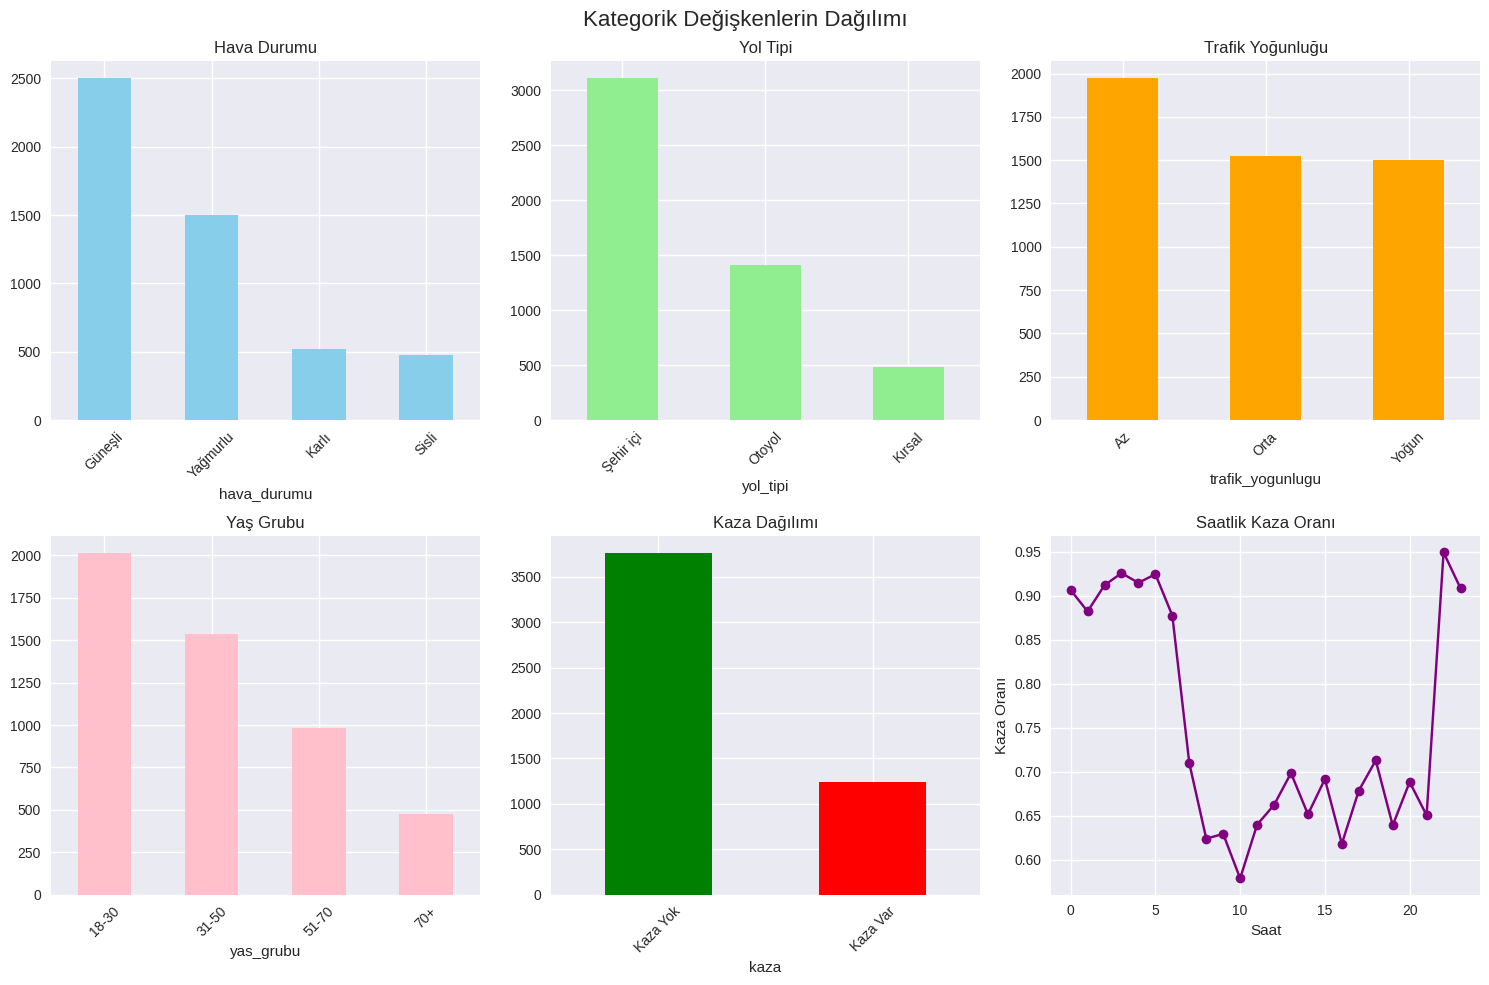

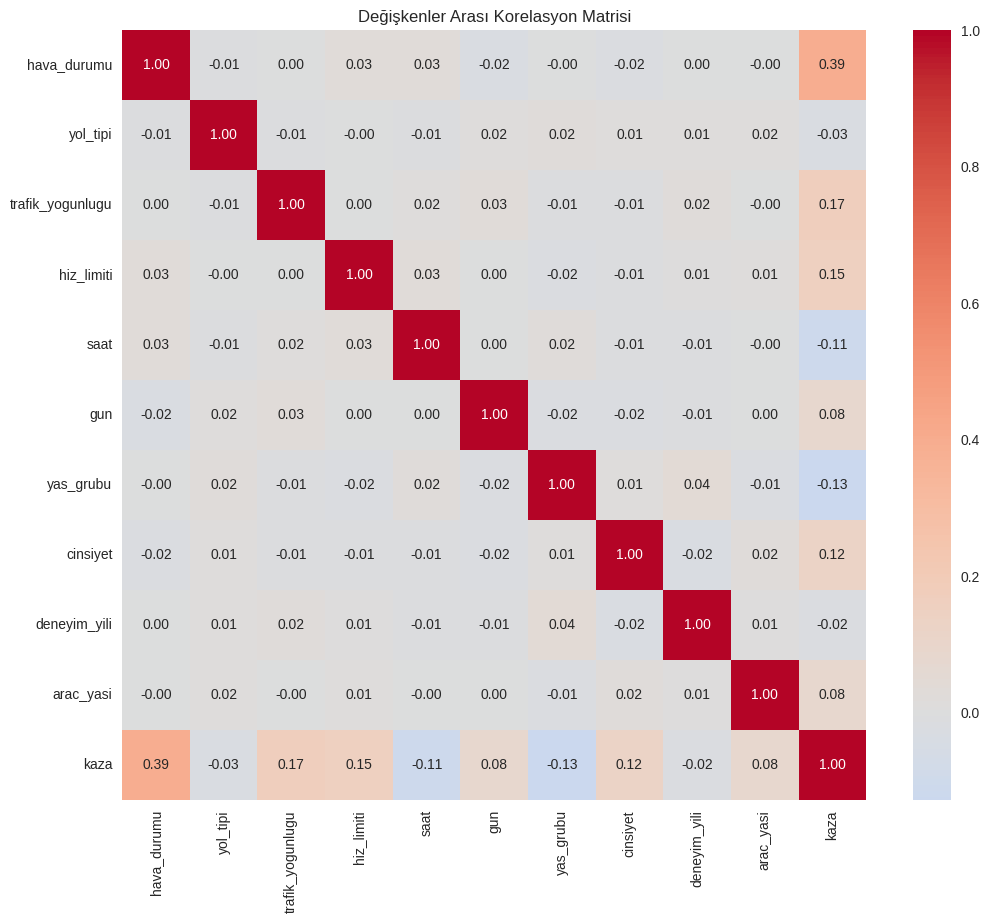

In [ ]:
# 3. Veri keşfi ve görselleştirme
print("\n📈 VERİ KEŞİFİ VE GÖRSELLEŞTİRME")
print("=" * 50)

# Temel istatistikler
print("Temel İstatistikler:")
print(df.describe())

# Eksik veri kontrolü
print(f"\nEksik veri sayısı:")
print(df.isnull().sum())

# Kategorik değişkenlerin dağılımı
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Kategorik Değişkenlerin Dağılımı', fontsize=16)

# Hava durumu
hava_labels = ['Güneşli', 'Yağmurlu', 'Karlı', 'Sisli']
df['hava_durumu'].value_counts().plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Hava Durumu')
axes[0,0].set_xticklabels(hava_labels, rotation=45)

# Yol tipi
yol_labels = ['Şehir içi', 'Otoyol', 'Kırsal']
df['yol_tipi'].value_counts().plot(kind='bar', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Yol Tipi')
axes[0,1].set_xticklabels(yol_labels, rotation=45)

# Trafik yoğunluğu
trafik_labels = ['Az', 'Orta', 'Yoğun']
df['trafik_yogunlugu'].value_counts().plot(kind='bar', ax=axes[0,2], color='orange')
axes[0,2].set_title('Trafik Yoğunluğu')
axes[0,2].set_xticklabels(trafik_labels, rotation=45)

# Yaş grubu
yas_labels = ['18-30', '31-50', '51-70', '70+']
df['yas_grubu'].value_counts().plot(kind='bar', ax=axes[1,0], color='pink')
axes[1,0].set_title('Yaş Grubu')
axes[1,0].set_xticklabels(yas_labels, rotation=45)

# Kaza dağılımı
kaza_labels = ['Kaza Yok', 'Kaza Var']
df['kaza'].value_counts().plot(kind='bar', ax=axes[1,1], color=['green', 'red'])
axes[1,1].set_title('Kaza Dağılımı')
axes[1,1].set_xticklabels(kaza_labels, rotation=45)

# Saatlik kaza dağılımı
kaza_saat = df.groupby('saat')['kaza'].mean()
kaza_saat.plot(kind='line', ax=axes[1,2], color='purple', marker='o')
axes[1,2].set_title('Saatlik Kaza Oranı')
axes[1,2].set_xlabel('Saat')
axes[1,2].set_ylabel('Kaza Oranı')

plt.tight_layout()
plt.show()

# Korelasyon matrisi
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Değişkenler Arası Korelasyon Matrisi')
plt.show()

In [ ]:
# 4. Veri ön işleme
print("\n🔧 VERİ ÖN İŞLEME")
print("=" * 50)

# Özellik ve hedef değişkenleri ayırma
X = df.drop('kaza', axis=1)
y = df['kaza']

print(f"Özellik sayısı: {X.shape[1]}")
print(f"Hedef değişken dağılımı:\n{y.value_counts()}")

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Eğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")

# Özellik ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


🔧 VERİ ÖN İŞLEME
Özellik sayısı: 10
Hedef değişken dağılımı:
kaza
1    3760
0    1240
Name: count, dtype: int64
Eğitim seti boyutu: (4000, 10)
Test seti boyutu: (1000, 10)


In [ ]:
# 5. Model eğitimi ve karşılaştırma
print("\n🤖 MODEL EĞİTİMİ VE KARŞILAŞTIRMA")
print("=" * 50)

# Farklı modeller tanımlama (Naive Bayes ve SVM kaldırıldı, MLP ve TabNet eklendi)
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'MLP (Neural Network)': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
    'TabNet': TabNetClassifier(input_dim=X_train.shape[1], epochs=50)
}

# Model performanslarını saklamak için
model_results = {}

# Import KFold for manual cross-validation
from sklearn.model_selection import KFold

for name, model in models.items():
    print(f"\n{name} modeli eğitiliyor...")

    # Ölçeklendirme gereksinimi
    if name in ['Logistic Regression', 'MLP (Neural Network)']:
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
        X_model = scaler.transform(X) # Ölçeklenmiş tam veri seti
    else:
        X_train_model = X_train
        X_test_model = X_test
        X_model = X # Ölçeklenmemiş tam veri seti

    # Model eğitimi
    if name == 'TabNet':
        # TabNet özel eğitim
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # TabNet için cross-validation manuel olarak
        cv_scores = []
        # KFold nesnesi oluştur
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        # Tam veri seti üzerinde çapraz doğrulama skorlarını hesapla
        # Her bir kat için modeli eğit ve test et
        for train_index, val_index in kf.split(X):
            X_train_fold, X_val_fold = X_model.iloc[train_index], X_model.iloc[val_index] # DataFrames ile iloc kullan
            y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index] # Series ile iloc kullan

            # TabNetClassifier fit method expects DataFrames or numpy arrays
            fold_model = TabNetClassifier(input_dim=X.shape[1], epochs=50) # Her kat için yeni model
            fold_model.fit(X_train_fold, y_train_fold)
            y_pred_fold = fold_model.predict(X_val_fold)
            cv_scores.append(accuracy_score(y_val_fold, y_pred_fold))

        cv_scores = np.array(cv_scores)
    else:
        model.fit(X_train_model, y_train)
        y_pred = model.predict(X_test_model)
        y_pred_proba = model.predict_proba(X_test_model)[:, 1] if hasattr(model, 'predict_proba') else None

        # Cross-validation
        if name in ['Logistic Regression', 'MLP (Neural Network)']:
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
        else:
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    # Performans metrikleri
    accuracy = accuracy_score(y_test, y_pred)

    model_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"Test Doğruluğu: {accuracy:.4f}")
    print(f"CV Doğruluğu: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")


🤖 MODEL EĞİTİMİ VE KARŞILAŞTIRMA

Logistic Regression modeli eğitiliyor...
Test Doğruluğu: 0.8320
CV Doğruluğu: 0.8275 (±0.0082)

Random Forest modeli eğitiliyor...
Test Doğruluğu: 0.9120
CV Doğruluğu: 0.8953 (±0.0077)

Gradient Boosting modeli eğitiliyor...
Test Doğruluğu: 0.9170
CV Doğruluğu: 0.9070 (±0.0096)

MLP (Neural Network) modeli eğitiliyor...


In [ ]:
# 6. Model performanslarının karşılaştırılması
print("\n📊 MODEL PERFORMANS KARŞILAŞTIRMASI")
print("=" * 50)

# Performans tablosu
performance_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Test Accuracy': [result['accuracy'] for result in model_results.values()],
    'CV Mean': [result['cv_mean'] for result in model_results.values()],
    'CV Std': [result['cv_std'] for result in model_results.values()]
})

performance_df = performance_df.sort_values('Test Accuracy', ascending=False)
print(performance_df.to_string(index=False))

# En iyi model
best_model_name = performance_df.iloc[0]['Model']
best_model = model_results[best_model_name]['model']
print(f"\n🏆 En iyi model: {best_model_name}")

In [ ]:
# 7. Detaylı model değerlendirmesi
print(f"\n🔍 {best_model_name.upper()} MODELİ DETAYLI DEĞERLENDİRME")
print("=" * 50)

# Confusion Matrix
y_pred_best = model_results[best_model_name]['y_pred']
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(12, 5))

# Confusion Matrix görselleştirmesi
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Kaza Yok', 'Kaza Var'],
            yticklabels=['Kaza Yok', 'Kaza Var'])
plt.title(f'{best_model_name} - Confusion Matrix')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')

# ROC Curve
if model_results[best_model_name]['y_pred_proba'] is not None:
    y_pred_proba_best = model_results[best_model_name]['y_pred_proba']
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
    auc_score = roc_auc_score(y_test, y_pred_proba_best)

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{best_model_name} - ROC Curve')
    plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Kaza Yok', 'Kaza Var']))

In [ ]:
# 8. Özellik önem analizi (Random Forest için)
if best_model_name == 'Random Forest':
    print("\n🎯 ÖZELLİK ÖNEM ANALİZİ")
    print("=" * 50)

    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("En önemli özellikler:")
    print(feature_importance.head(10).to_string(index=False))

    # Özellik önem görselleştirmesi
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature', palette='viridis')
    plt.title('Özellik Önem Sıralaması (Random Forest)')
    plt.xlabel('Önem Skoru')
    plt.tight_layout()
    plt.show()

In [ ]:
# 9. Hiperparametre optimizasyonu (en iyi model için)
print(f"\n⚙️ {best_model_name.upper()} HİPERPARAMETRE OPTİMİZASYONU")
print("=" * 50)

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }

    grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                              param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"En iyi parametreler: {grid_search.best_params_}")
    print(f"En iyi CV skoru: {grid_search.best_score_:.4f}")

    # Optimize edilmiş modeli test et
    optimized_model = grid_search.best_estimator_
    y_pred_optimized = optimized_model.predict(X_test)
    optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
    print(f"Optimize edilmiş model test doğruluğu: {optimized_accuracy:.4f}")

elif best_model_name == 'MLP (Neural Network)':
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100)],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }

    grid_search = GridSearchCV(MLPClassifier(max_iter=500, random_state=42),
                              param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    print(f"En iyi parametreler: {grid_search.best_params_}")
    print(f"En iyi CV skoru: {grid_search.best_score_:.4f}")

    # Optimize edilmiş modeli test et
    optimized_model = grid_search.best_estimator_
    y_pred_optimized = optimized_model.predict(X_test_scaled)
    optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
    print(f"Optimize edilmiş model test doğruluğu: {optimized_accuracy:.4f}")

elif best_model_name == 'TabNet':
    print("TabNet için hiperparametre optimizasyonu:")

    # Manuel hiperparametre test etme
    best_params = {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'epochs': 50}
    # best_score = model_results[best_model_name]['accuracy'] # Use CV score for comparison
    # Calculate initial CV score for the default params
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    initial_cv_scores = []
    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X_model.iloc[train_index], X_model.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
        fold_model = TabNetClassifier(input_dim=X.shape[1], **best_params)
        fold_model.fit(X_train_fold, y_train_fold)
        y_pred_fold = fold_model.predict(X_val_fold)
        initial_cv_scores.append(accuracy_score(y_val_fold, y_pred_fold))
    best_score = np.mean(initial_cv_scores)


    # Farklı parametreler test et
    param_combinations = [
        {'n_d': 64, 'n_a': 64, 'n_steps': 4, 'epochs': 75},
        {'n_d': 32, 'n_a': 32, 'n_steps': 5, 'epochs': 100},
        {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'epochs': 50}
    ]

    for params in param_combinations:
        print(f"Test ediliyor: {params}")
        # Calculate CV score for current params
        temp_cv_scores = []
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        for train_index, val_index in kf.split(X):
             X_train_fold, X_val_fold = X_model.iloc[train_index], X_model.iloc[val_index]
             y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
             temp_model = TabNetClassifier(input_dim=X.shape[1], **params)
             temp_model.fit(X_train_fold, y_train_fold)
             y_pred_fold = temp_model.predict(X_val_fold)
             temp_cv_scores.append(accuracy_score(y_val_fold, y_pred_fold))

        temp_score = np.mean(temp_cv_scores)

        if temp_score > best_score:
            best_score = temp_score
            best_params = params

    print(f"En iyi parametreler: {best_params}")
    print(f"En iyi CV doğruluğu: {best_score:.4f}")

    # En iyi parametrelerle final model
    # Train the final optimized model on the full training data
    optimized_model = TabNetClassifier(input_dim=X_train.shape[1], **best_params)
    optimized_model.fit(X_train, y_train)
    y_pred_optimized = optimized_model.predict(X_test)
    optimized_accuracy = accuracy_score(y_test, y_pred_optimized)
    print(f"Optimize edilmiş model test doğruluğu: {optimized_accuracy:.4f}")


else:
    print(f"{best_model_name} için özel hiperparametre optimizasyonu tanımlanmamış.")

In [ ]:
# 10. Örnek tahmin fonksiyonu
def predict_accident_risk(hava_durumu, yol_tipi, trafik_yogunlugu, hiz_limiti,
                         saat, gun, yas_grubu, cinsiyet, deneyim_yili, arac_yasi):
    """
    Verilen parametreler için kaza riskini tahmin eder
    """
    # Örnek veri oluştur
    sample_data = np.array([[hava_durumu, yol_tipi, trafik_yogunlugu, hiz_limiti,
                           saat, gun, yas_grubu, cinsiyet, deneyim_yili, arac_yasi]])

    # Convert to DataFrame for column handling
    sample_df = pd.DataFrame(sample_data, columns=X.columns)

    # Ölçeklendirme (gerekirse)
    if best_model_name in ['Logistic Regression', 'MLP (Neural Network)']:
        sample_data_processed = scaler.transform(sample_df)
    elif best_model_name == 'TabNet':
        # TabNet kendi ölçeklendirmesini yapar, ancak fit sırasında kullanılan scaler'ı kullanmalıyız
        # Burada best_model'ın içindeki scaler'ı kullanıyoruz
        sample_data_processed = best_model.scaler.transform(sample_df)
    else:
        sample_data_processed = sample_df.values # Diğer modeller için array

    # Tahmin
    if best_model_name == 'TabNet':
        # TabNet predict/predict_proba methods expect DataFrames or numpy arrays
        prediction = best_model.predict(sample_df)[0]
        probability = best_model.predict_proba(sample_df)[0][1]
    else:
        prediction = best_model.predict(sample_data_processed)[0]
        if hasattr(best_model, 'predict_proba'):
            probability = best_model.predict_proba(sample_data_processed)[0][1]
        else:
            probability = None

    return prediction, probability

# Örnek tahmin
print("\n🎯 ÖRNEK TAHMİN")
print("=" * 50)

# Yağmurlu havada, otoyolda, yoğun trafikte, genç sürücü
prediction, probability = predict_accident_risk(
    hava_durumu=1,      # Yağmurlu
    yol_tipi=1,         # Otoyol
    trafik_yogunlugu=2, # Yoğun
    hiz_limiti=120,     # 120 km/h
    saat=22,            # Gece 22:00
    gun=5,              # Cumartesi
    yas_grubu=0,        # 18-30 yaş
    cinsiyet=1,         # Erkek
    deneyim_yili=1,     # 1 yıl deneyim
    arac_yasi=15        # 15 yaşında araç
)

print("Senaryo: Yağmurlu havada, otoyolda, yoğun trafikte, gece saatlerinde, genç erkek sürücü")
print(f"Kaza tahmini: {'Kaza Riski Var' if prediction == 1 else 'Kaza Riski Düşük'}")
if probability:
    print(f"Kaza olasılığı: %{probability*100:.1f}")